# A Finite Element Examples: Frame 01

This example is based on the frame01 example distributed with FEM.edu

## Load needed components

We need to add the local code to the path or python won't find FEM.edu

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join("..")))

Now load the needed components of FEM.edu

In [2]:
from femedu.domain import *
from femedu.solver.NewtonRaphsonSolver import *
from femedu.elements.Frame2D import *
from femedu.materials.ElasticSection import *

## Build a model

In [3]:
# ========== setting mesh parameters ==============

N = 8                                   # number of elements in the mesh

# do not use alpha = 0 or your model will have elements with length = 0.0 and the axial direction is undefined.
alpha=np.linspace(0.05,.95,10)          # alpha value

L = 100.0                               # column free length

gamma = 2.


# ========== setting material parameters ==============

params = dict(
    E = 20000.,    # Young's modulus
    A = 100.0,     # cross section area
    I = 10.0       # cross section moment of inertia
    #gamma=2
)

params2 = dict(
    E = 20000.,    # Young's modulus
    A = 100.0,     # cross section area
    I = 10.0 * gamma       # cross section moment of inertia
)

# ========== setting load parameters ==============

w   = 0.01        # uniform lateral load on the column
Pcr = np.pi**2 * params['E'] * params['I'] / L**2    # Euler buckling load

# ========== setting analysis parameters ==============

target_load_level = 0.99      # 99% of Euler load
max_steps = 10                # solve max_steps points on the primary path


w   *= 0.01
#Pcr *= 0.01    # PETER SAYS: I turned that off


# define a list of target load levels
load_levels = np.linspace(0, target_load_level, max_steps)

#
# ==== Build the system model ====
#

model = []

for a in range(10):
    model.append(System())

    model[a].setSolver(NewtonRaphsonSolver())

    # create nodes

    nd0 = Node(0.0, 0.0)

    model[a] += nd0


    ndi = nd0

    y=0

    #params['E']
    for i in range(N):
        # nodes
        y+=(0.5*alpha[a])*L/N
        ndj = Node(0.0, y)  
        model[a] += ndj

        # elements
        elem = Frame2D(ndi, ndj, ElasticSection(params2))
        model[a] += elem

        # ** apply the element portion of the reference load
        elem.setDistLoad(w)

        ndi = ndj    # jump to next element: make current end-node the next start-node

    #params['E']=
    for i in range(N):
        # nodes
        y+=(1-alpha[a])*L/N
        ndj = Node(0.0, y)  
        model[a] += ndj

        # elements
        elem = Frame2D(ndi, ndj, ElasticSection(params))
        model[a] += elem

        # ** apply the element portion of the reference load
        elem.setDistLoad(w)

        ndi = ndj    # jump to next element: make current end-node the next start-node
                 
    #params['E']
    for i in range(N):
        # nodes
        y+=(0.5*alpha[a])*L/N
        ndj = Node(0.0,y)  
        model[a] += ndj
    
        # elements
        elem = Frame2D(ndi, ndj, ElasticSection(params2))
        model[a] += elem

        # ** apply the element portion of the reference load
        elem.setDistLoad(w)

        ndi = ndj    # jump to next element: make current end-node the next start-node
                 
    # define support(s)

    nd0.fixDOF('ux', 'uy')    # horizontal support left end
    ndi.fixDOF('ux')          # vertical support right end

    # ==== complete the reference load ====

    # these are only nodal forces as part of the reference load
    # .. load only the upper node
    ndi.setLoad((-Pcr,), ('uy',))



## Analyze the model

In [4]:

model[9].solve(verbose=True)

model[9].report()


norm of the out-of-balance force:   1.9739e+02
norm of the out-of-balance force:   1.0773e-03
norm of the out-of-balance force:   1.1192e-10
+

System Analysis Report

Nodes:
---------------------
  Node_0:
      x:    [0. 0.]
      fix:  ['ux', 'uy']
      u:    [0.00000000e+00 0.00000000e+00 2.46974208e-05]
  Node_1:
      x:    [0.     5.9375]
      u:    [-1.45793356e-04 -5.86007761e-04  2.42715979e-05]
  Node_2:
      x:    [ 0.    11.875]
      u:    [-2.86622309e-04 -1.17201552e-03  2.30363502e-05]
  Node_3:
      x:    [ 0.     17.8125]
      u:    [-4.17893073e-04 -1.75802328e-03  2.10653904e-05]
  Node_4:
      x:    [ 0.   23.75]
      u:    [-5.35488163e-04 -2.34403105e-03  1.84452121e-05]
  Node_5:
      x:    [ 0.     29.6875]
      u:    [-6.35837927e-04 -2.93003881e-03  1.52735868e-05]
  Node_6:
      x:    [ 0.    35.625]
      u:    [-7.15982557e-04 -3.51604657e-03  1.16578660e-05]
  Node_7:
      x:    [ 0.     41.5625]
      u:    [-7.73623504e-04 -4.10205433e-03  7

# create plots
print(model)

model.setLoadFactor(0.5)
model.solve()
print(model)
        
model.plot(factor=10000.0)

model.beamValuePlot("F")
model.beamValuePlot("M")
model.beamValuePlot("V")

## Stability Analysis

In [5]:
# initialize the analysis:

lambdas = [ [] for i in range(10) ]  # create an empty list of lambdas for each model!
detKts  = [ [] for i in range(10) ]  # create an empty list of det(Kt)s for each model!

# loop through your models
for i in range(10):
    
    # now analyze the i-th model
    for load_level in load_levels:
        
        # Kt   = []
        model[i].resetDisplacements()                # set U to all zeros
        model[i].setLoadFactor(load_level)           # WAS WRONG: define a known equilibrium solution
        # This sets the target load level.  
        # - It should be an equilibrium state (if no thermal or plastic loads are present)
        # - but you need to call model.solve() to assemble internal force (equilibrium check) and Kt

        #Kt=model[i].getSolver(assemble())
        #lambdas[i]=Kt.getBucklingMode(mode=0)

        model[i].solve()                           # you need to find the primary path first
        detKt = model[i].solver.checkStability()   # stability check: returns detKt for small systems, min eigenvalue for larger ones

        # the current lambda is 0.0 (your target load factor)
        lambdas[i].append(load_level)
        detKts[i].append(detKt)
        
        if detKt < 0.0:   # PETER SAYS: this load level went just past the critical one!
            break         # ... stop applying more load - you have everything you need

        #model.startRecorder()        # not doing anything yet, but will do the data collection soon

        #detKt   = []
        #lambdas = []
        
    # PETER SAYS: At this point, you have a load-history dataset for model[i]
    # ... this would be the perfect spot to extrapolate/interpolate detKt for the i-th model 
    # ... and find the critical lambda
    

# solve for all load_levels
"""for loadfactor in load_levels:

    # define node X2 as the controled node; downward direction is prescribed:
    model.setLoadFactor(loadfactor)
    model.solve(verbose=True)

    # stability check
    lambdas.append(model.loadfactor)
    detKt.append(model.solver.checkStability())

    # report results
    print('+')
    #model.report()

    print("\n=== next load level ===\n")"""


norm of the out-of-balance force:   0.0000e+00
+

 ** Stability check: (smallest eigenvalue of Kt) = 2.2903077286447036

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   3.8716e-05
norm of the out-of-balance force:   1.1613e-08
+

 ** Stability check: (smallest eigenvalue of Kt) = 2.0384174324863458

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   8.6997e-05
norm of the out-of-balance force:   5.8849e-08
+

 ** Stability check: (smallest eigenvalue of Kt) = 1.7865028235068434

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   1.4888e-04
norm of the out-of-balance force:   2.0385e-08
+

 ** Stability check: (smallest eigenvalue of Kt) = 1.534589182199325

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   2.3107e-04
norm of the out-of-balance force:   1.3800e-08
+

 ** Stability check: (smallest eigenvalue of Kt) = 1.2826922984294284

norm of the out-of-b

norm of the out-of-balance force:   1.8491e-03
norm of the out-of-balance force:   1.8939e-09
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.0586958904112216

norm of the out-of-balance force:   0.0000e+00
+

 ** Stability check: (smallest eigenvalue of Kt) = 1.214780886775099

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   2.6759e-05
norm of the out-of-balance force:   4.9691e-11
+

 ** Stability check: (smallest eigenvalue of Kt) = 1.0900661336710697

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   5.9684e-05
norm of the out-of-balance force:   9.3700e-11
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.9653100058701543

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   1.0117e-04
norm of the out-of-balance force:   6.1284e-12
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.8405116313418685

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-b

norm of the out-of-balance force:   0.0000e+00
+

 ** Stability check: (smallest eigenvalue of Kt) = 1.0129984118460398

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   1.3355e-05
norm of the out-of-balance force:   7.0454e-12
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.9403454209085524

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   2.8754e-05
norm of the out-of-balance force:   1.1050e-11
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.8676907855508202

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   4.6711e-05
norm of the out-of-balance force:   2.8661e-12
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.7950344737068089

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   6.7928e-05
norm of the out-of-balance force:   1.7560e-12
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.7223764505013316

norm of the out-of-

'for loadfactor in load_levels:\n\n    # define node X2 as the controled node; downward direction is prescribed:\n    model.setLoadFactor(loadfactor)\n    model.solve(verbose=True)\n\n    # stability check\n    lambdas.append(model.loadfactor)\n    detKt.append(model.solver.checkStability())\n\n    # report results\n    print(\'+\')\n    #model.report()\n\n    print("\n=== next load level ===\n")'

In [6]:
# these are the recorded load levels for each model:
lambdas

[[0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99]]

In [7]:
# these are the recorded detKts (or eigenvalues) for each model:
detKts

[[2.2903077286447036,
  2.0384174324863458,
  1.7865028235068434,
  1.534589182199325,
  1.2826922984294284,
  1.0307869641577279,
  0.7788811092654264,
  0.5269699376997034,
  0.27505215882144757,
  0.023133400635404637],
 [1.9666649389846331,
  1.7509915933219524,
  1.5353042600103564,
  1.319596816312997,
  1.1038725435132637,
  0.8881305632607062,
  0.6723703399995636,
  0.4565910514033116,
  0.24079248236105186,
  0.024974550796057524],
 [1.6526677222979005,
  1.4732765246014385,
  1.2938433318210096,
  1.1143674342924457,
  0.9348475842898083,
  0.755282983148694,
  0.5756723978835434,
  0.39601474458765995,
  0.2163089191016256,
  0.03655358627011102],
 [1.3996894157807205,
  1.2509028244452762,
  1.1020658842535398,
  0.9531774246043833,
  0.8042362801153892,
  0.6552412232596507,
  0.5061909794836656,
  0.3570842702732725,
  0.20791970113906,
  0.0586958904112216],
 [1.214780886775099,
  1.0900661336710697,
  0.9653100058701543,
  0.8405116313418685,
  0.7156700549934372,
  0.

### Summary

The following plot shows detKt over applied load level for your 10 models.

You will need the following to complete the stability analysis for all of these:

* extrapolate (or interpolate) $det{\bf K}_t$ and find where it goes through zero. That $\lambda$ is your $\lambda_{cr}$.
* collect those $\lambda_{cr}$ for each model and plot $\lambda_{cr}$ over $\alpha$ and you have the reuested stability graph.

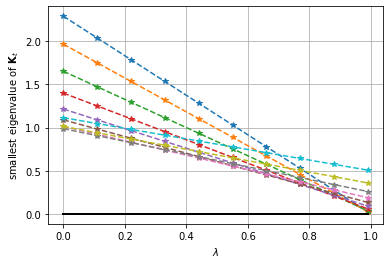

In [8]:
for lam, dKt in zip(lambdas, detKts):
    
    plt.plot(lam, dKt, '--*')

    # add a black zero line
    plt.plot(lam, np.zeros_like(lam), '-k')

plt.xlabel("$\lambda$")
plt.ylabel("smallest eigenvalue of ${\\bf K}_t$")
plt.grid(True)
plt.show()

This looks like those curces are (or nearly are) linear.  You can find the critical value by interpolating between the last two values.

Interpolation works as
$$
   f(\lambda) = \frac{\lambda_1 - \lambda}{\lambda_1 - \lambda_0}\,f_0 
    + \frac{\lambda - \lambda_0}{\lambda_1 - \lambda_0}\,f_1 
$$
and $\lambda_{cr}$ follows from
$$
    f(\lambda_{cr}) = 0 
    \qquad\Rightarrow\qquad
    \lambda_{cr} = \frac{(f_1 \,\lambda_0 - f_0\,\lambda_1)}{(f_1 - f_0)}
$$

Here is how to fetch those values for model `i`:
```
# pick a model:
i = 1

lam0 = lambdas[i][-2]  # second to last in the list
lam1 = lambdas[i][-1]  # last in the list

f0 = lambdas[i][-2]  # second to last in the list
f1 = lambdas[i][-1]  # last in the list
```


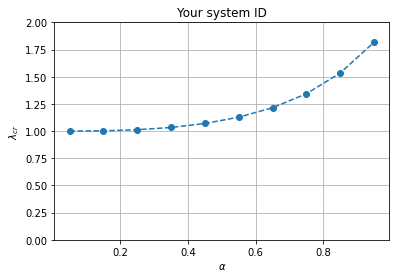

In [9]:
lam_cr_s = []

for i in range(len(alpha)):

    lam0 = lambdas[i][-2]  # second to last in the list
    lam1 = lambdas[i][-1]  # last in the list

    f0 = detKts[i][-2]  # second to last in the list
    f1 = detKts[i][-1]  # last in the list
    
    lam_cr = (f1*lam0 - f0*lam1) / (f1 - f0)
    
    lam_cr_s.append( lam_cr )
    
plt.plot(alpha, lam_cr_s, '--o')
plt.grid(True)
plt.ylim(0.0, 2.0)
plt.xlabel('$\\alpha $')
plt.ylabel('$\\lambda_{cr}$')
plt.title('Your system ID')
plt.show()

In [10]:
#
# ==== check the current state of the model ===
#

for mod in model:
    mod.report()


System Analysis Report

Nodes:
---------------------
  Node_0:
      x:    [0. 0.]
      fix:  ['ux', 'uy']
      u:    [0.         0.         0.00200959]
  Node_1:
      x:    [0.     0.3125]
      u:    [-6.27991712e-04 -3.05340886e-05  2.00954112e-03]
  Node_2:
      x:    [0.    0.625]
      u:    [-1.25595309e-03 -6.10681772e-05  2.00939550e-03]
  Node_3:
      x:    [0.     0.9375]
      u:    [-1.88385379e-03 -9.16022658e-05  2.00915283e-03]
  Node_4:
      x:    [0.   1.25]
      u:    [-0.00251166 -0.00012214  0.00200881]
  Node_5:
      x:    [0.     1.5625]
      u:    [-0.00313935 -0.00015267  0.00200838]
  Node_6:
      x:    [0.    1.875]
      u:    [-0.00376689 -0.0001832   0.00200784]
  Node_7:
      x:    [0.     2.1875]
      u:    [-0.00439424 -0.00021374  0.00200721]
  Node_8:
      x:    [0.  2.5]
      u:    [-0.00502139 -0.00024427  0.00200648]
  Node_9:
      x:    [ 0.    14.375]
      u:    [-0.02795268 -0.00140457  0.0018107 ]
  Node_10:
      x:    [ 0.   

ValueError: x and y must have same first dimension, but have shapes (10, 10) and (1,)

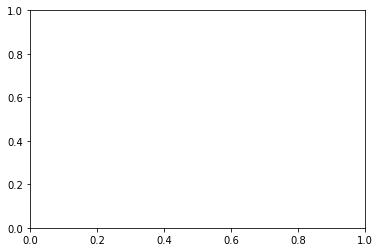

In [11]:
#
# ==== create some nice plots ===
#

plt.plot(lambdas,detKt,'--*r')
plt.grid(True)
plt.xlabel('Load factor, $ \lambda $')
plt.ylabel("Stability index, $ {det}\: {\\bf K}_t $")
plt.show()

model.plot(factor=1.0)

model.beamValuePlot("F")
model.beamValuePlot("M")
model.beamValuePlot("V")

model.plotBucklingMode(factor=10.)
